In [61]:
import pandas as pd

In [62]:
# Load healthcare reviews dataset
health_df = pd.read_csv("healthcare_reviews.csv")

# Quick checks
print("Health:", health_df.shape)

health_df.head()

Health: (70777, 20)


,rating,title,status,pros,cons,advice,recommend,ceo_approval,business_outlook,career_opportunities,compensation_and_benefits,senior_management,work_life_balance,culture_and_values,diversity_and_inclusion,firm_link,date,job,index,firm_id
0,5.0,It’s a dream!,"Current Employee, more than 1 year",Work from home. Wonderful team - feels like fa...,I get tired of being at home ….but I’d rather ...,NaN,1.0,0.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,Reviews/Humana-Reviews-E340.htm,NaN,RN Case Manager,NaN,E340
1,4.0,The leader makes or breaks job satisfaction,"Former Employee, more than 10 years",I have held positions across the company for 1...,There were roles where the leader was a microm...,NaN,1.0,1.0,1.0,4.0,5.0,3.0,4.0,4.0,5.0,Reviews/Humana-Reviews-E340.htm,NaN,Regional Manager,NaN,E340
2,5.0,Great place to work,Current Employee,"Love the company . Room for Movement, work fro...","Varies per supervisor, yearly raises could be ...",NaN,1.0,1.0,1.0,5.0,5.0,3.0,4.0,5.0,5.0,Reviews/Humana-Reviews-E340.htm,NaN,Claims Specialist,NaN,E340
3,4.0,Great company,Current Employee,"Great company to work for, they definitely foc...","It is a health care company, so there is some ...",NaN,1.0,1.0,1.0,5.0,4.0,2.0,3.0,5.0,5.0,Reviews/Humana-Reviews-E340.htm,NaN,Consumer Engagement Professional,NaN,E340
4,5.0,Flexible and good benefits,"Current Employee, more than 3 years",Great PTO and flexibility. Work at home opport...,Recent layoffs and restructuring created stres...,NaN,1.0,1.0,-1.0,5.0,5.0,5.0,5.0,3.0,3.0,Reviews/Humana-Reviews-E340.htm,NaN,Provider Relations Representative,NaN,E340


In [63]:
# Combine review columns (use what you actually have)
health_df["text"] = (
    health_df["title"].fillna("") + " " +
    health_df["pros"].fillna("") + " " +
    health_df["cons"].fillna("")
)

In [64]:
# pre-process
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)

lemmatizer = WordNetLemmatizer()

In [65]:
# add company names to stopwords

# List of healthcare + infrastructure companies
company_names = [
    "Mayo Clinic", "Kaiser Permanente", "Cleveland Clinic", "Johns Hopkins",
    "HCA Healthcare", "UnitedHealth Group", "CVS Health", "Humana", "Cigna",
    "Tenet Healthcare", "Pfizer", "Johnson & Johnson", "Roche", "GSK",

    "Bechtel", "Jacobs", "AECOM", "Fluor", "Kiewit", "Skanska",
    "Turner Construction", "Vinci", "Balfour Beatty", "AtkinsRéalis",
    "DPR Construction", "Arcadis", "Parsons", "HDR", "WSP"
]

# Convert names → tokens appearing in text
def normalize_company(name):
    name = name.lower()
    name = re.sub(r"[^a-z0-9 ]", " ", name) # remove punctuation
    tokens = name.split()
    return tokens

# Build flattened list of stopwords
company_stopwords = set()
for comp in company_names:
    for token in normalize_company(comp):
        company_stopwords.add(token)

company_stopwords

{'aecom',
 'alis',
 'arcadis',
 'atkinsr',
 'balfour',
 'beatty',
 'bechtel',
 'cigna',
 'cleveland',
 'clinic',
 'construction',
 'cvs',
 'dpr',
 'fluor',
 'group',
 'gsk',
 'hca',
 'hdr',
 'health',
 'healthcare',
 'hopkins',
 'humana',
 'jacobs',
 'johns',
 'johnson',
 'kaiser',
 'kiewit',
 'mayo',
 'parsons',
 'permanente',
 'pfizer',
 'roche',
 'skanska',
 'tenet',
 'turner',
 'unitedhealth',
 'vinci',
 'wsp'}

In [66]:
# base stopwords
stop_words = set(stopwords.words("english"))

# add company stopwords
stop_words |= company_stopwords

stop_words = list(stop_words)

In [67]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 2]
    return tokens

health_df["tokens"] = health_df["text"].apply(preprocess)

In [68]:
# build bi-grams
from gensim.models import Phrases
from gensim.models.phrases import Phraser

bigram = Phrases(health_df["tokens"], min_count=10, threshold=15)
bigram_mod = Phraser(bigram)

health_df["tokens"] = health_df["tokens"].apply(lambda x: bigram_mod[x])

In [69]:
# convert to LDA format
from gensim.corpora import Dictionary

dictionary = Dictionary(health_df["tokens"])
dictionary.filter_extremes(no_below=20, no_above=0.5)

corpus = [dictionary.doc2bow(tokens) for tokens in health_df["tokens"]]

In [70]:
# train LDA model
from gensim.models import LdaModel

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=6,
    random_state=42,
    passes=10,
    alpha="auto"
)

In [71]:
# print topics
for i, topic in lda_model.show_topics(num_topics=6, num_words=10, formatted=False):
    print(f"Topic {i}: {[w for w, p in topic]}")

Topic 0: ['patient', 'facility', 'care', 'pension', 'intern', 'medicine', 'career_progression', 'resume', 'understaffed', 'world_class']
Topic 1: ['nothing', 'research', 'none', 'love', 'everything', 'say', 'rochester', 'lab', 'pro', 'tech']
Topic 2: ['pay', 'management', 'hour', 'job', 'staff', 'low', 'long', 'poor', 'care', 'time']
Topic 3: ['work', 'great', 'good', 'company', 'benefit', 'place', 'people', 'opportunity', 'environment', 'lot']
Topic 4: ['change', 'leadership', 'value', 'organization', 'culture', 'process', 'large', 'development', 'business', 'level']
Topic 5: ['get', 'employee', 'manager', 'year', 'one', 'like', 'make', 'time', 'take', 'new']


In [59]:
import warnings
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        print(f"Training LDA with {num_topics} topics...")

        # ignore warnings for simple display
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
        
            model = LdaModel(
                corpus=corpus,
                id2word=dictionary,
                num_topics=num_topics,
                random_state=42,
                passes=10,
                alpha="auto"
            )
        
        model_list.append(model)
        
        coherencemodel = CoherenceModel(
            model=model, 
            texts=texts, 
            dictionary=dictionary, 
            coherence='c_v'
        )
        
        coherence = coherencemodel.get_coherence()
        coherence_values.append(coherence)
        print(f" → Coherence = {coherence:.4f}")
    
    return model_list, coherence_values

In [60]:
# tuning
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=health_df["tokens"],
    start=2,
    limit=20
)

Training LDA with 2 topics...


/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/norazhan/Library/Python/3.9/lib/python/site-packages/gensim/__init__.py", line 11, in <module>
    from gensim import parsing, corpora, matutils, interfaces, models, similarities, utils  # noqa:F401
  File "/Users/norazhan/Library/Pyth

KeyboardInterrupt: 

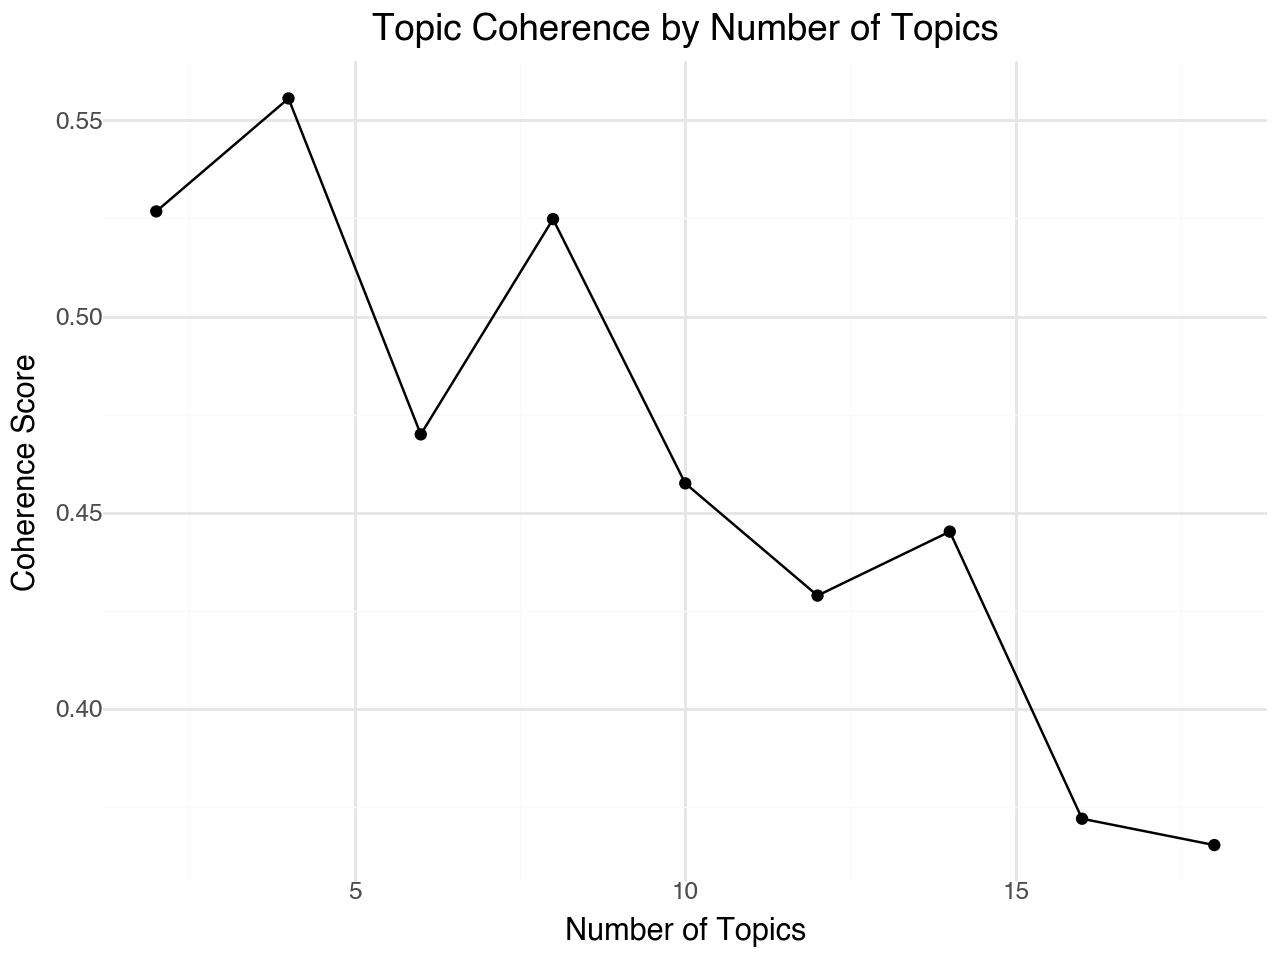

In [33]:
# visualize
topic_range = list(range(2, 20, 2))

health_df_plot = pd.DataFrame({
    "num_topics": topic_range,
    "coherence": coherence_values
})

from plotnine import ggplot, aes, geom_line, geom_point, labs, theme_minimal

(
    ggplot(health_df_plot, aes(x="num_topics", y="coherence"))
    + geom_line()
    + geom_point()
    + labs(
        title="Topic Coherence by Number of Topics",
        x="Number of Topics",
        y="Coherence Score"
    )
    + theme_minimal()
)

In [35]:
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=4,
    random_state=42,
    passes=10,
    alpha="auto"
)

for i, topic in lda_model.show_topics(num_topics=4, num_words=10, formatted=False):
    print(f"Topic {i}: {[w for w, p in topic]}")

Topic 0: ['patient', 'care', 'hospital', 'research', 'nurse', 'medical', 'employee', 'staff', 'quality', 'number']
Topic 1: ['get', 'employee', 'year', 'one', 'job', 'like', 'make', 'people', 'time', 'really']
Topic 2: ['pay', 'management', 'hour', 'job', 'staff', 'manager', 'low', 'time', 'long', 'poor']
Topic 3: ['work', 'great', 'good', 'company', 'benefit', 'place', 'people', 'opportunity', 'environment', 'culture']


# Infrastructure

In [36]:
# Load infrastructure reviews dataset
infra_df = pd.read_csv("infrastructure_reviews.csv")

print("Infrastructure:", infra_df.shape)

infra_df.head()

Infrastructure: (16734, 20)


,rating,title,status,pros,cons,advice,recommend,ceo_approval,business_outlook,career_opportunities,compensation_and_benefits,senior_management,work_life_balance,culture_and_values,diversity_and_inclusion,firm_link,date,job,index,firm_id
0,5.0,Overall Good Oil and Gas Company,Former Employee,I love the corporate culture,The outsourcing for IT didn't work,NaN,0.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,https://www.glassdoor.com/Reviews/SNC-Lavalin-...,2023-01-25,IT Technician,NaN,E8810
1,3.0,Very easy work not really learning,"Former Employee, less than 1 year",Good pay reasonable work and near transit,hard to find work and not helpful at learning ...,NaN,1.0,NaN,NaN,2.0,4.0,3.0,3.0,3.0,5.0,https://www.glassdoor.com/Reviews/SNC-Lavalin-...,2023-03-28,Mechanical Engineer,NaN,E8810
2,3.0,Great work,Current Employee,"Good benefits, good pay, good work culture",Work life balance is not the best,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,https://www.glassdoor.com/Reviews/SNC-Lavalin-...,2023-01-23,Business Analyst,NaN,E8810
3,2.0,Field Team,Former Employee,"Variety in the day, opportunity to take on sev...","Long days, mediocre pay, frequent lay offs",NaN,0.0,0.0,0.0,2.0,2.0,2.0,1.0,1.0,1.0,https://www.glassdoor.com/Reviews/SNC-Lavalin-...,2023-01-09,Field Purchasing Manager,NaN,E8810
4,4.0,Good,"Current Employee, more than 3 years",Good work culture Good coworkers,Not any cons I can think of,NaN,1.0,NaN,NaN,5.0,4.0,5.0,5.0,4.0,5.0,https://www.glassdoor.com/Reviews/SNC-Lavalin-...,2023-01-11,Designer,NaN,E8810


In [48]:
# Combine review columns (use what you actually have)
infra_df["text"] = (
    infra_df["title"].fillna("") + " " +
    infra_df["pros"].fillna("") + " " +
    infra_df["cons"].fillna("")
)

In [49]:
infra_df["tokens"] = infra_df["text"].apply(preprocess)

bigram_infra = Phrases(infra_df["tokens"], min_count=10, threshold=15)
bigram_mod_infra = Phraser(bigram_infra)

infra_df["tokens"] = infra_df["tokens"].apply(lambda x: bigram_mod_infra[x])

In [50]:
# convert to LDA format
from gensim import corpora
dictionary_infra = corpora.Dictionary(infra_df["tokens"])
dictionary_infra.filter_extremes(no_below=10, no_above=0.5)

corpus_infra = [dictionary_infra.doc2bow(tokens) for tokens in infra_df["tokens"]]

In [51]:
# train LDA model
lda_model_infra = LdaModel(
    corpus=corpus_infra,
    id2word=dictionary_infra,
    num_topics=6,
    random_state=42,
    passes=10,
    alpha="auto"
)

In [52]:
# tuning
model_list_infra, coherence_values_infra = compute_coherence_values(
    dictionary=dictionary_infra,
    corpus=corpus_infra,
    texts=infra_df["tokens"],
    start=2,
    limit=20,
    step=2
)

Training LDA with 2 topics...


/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is c

 → Coherence = 0.4602
Training LDA with 4 topics...


/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is c

 → Coherence = 0.5604
Training LDA with 6 topics...


/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is c

 → Coherence = 0.5295
Training LDA with 8 topics...


/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is c

 → Coherence = 0.4887
Training LDA with 10 topics...


/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is c

 → Coherence = 0.4781
Training LDA with 12 topics...


/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is c

 → Coherence = 0.4769
Training LDA with 14 topics...


/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is c

 → Coherence = 0.4601
Training LDA with 16 topics...


/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is c

 → Coherence = 0.4446
Training LDA with 18 topics...


/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/norazhan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is c

 → Coherence = 0.4436


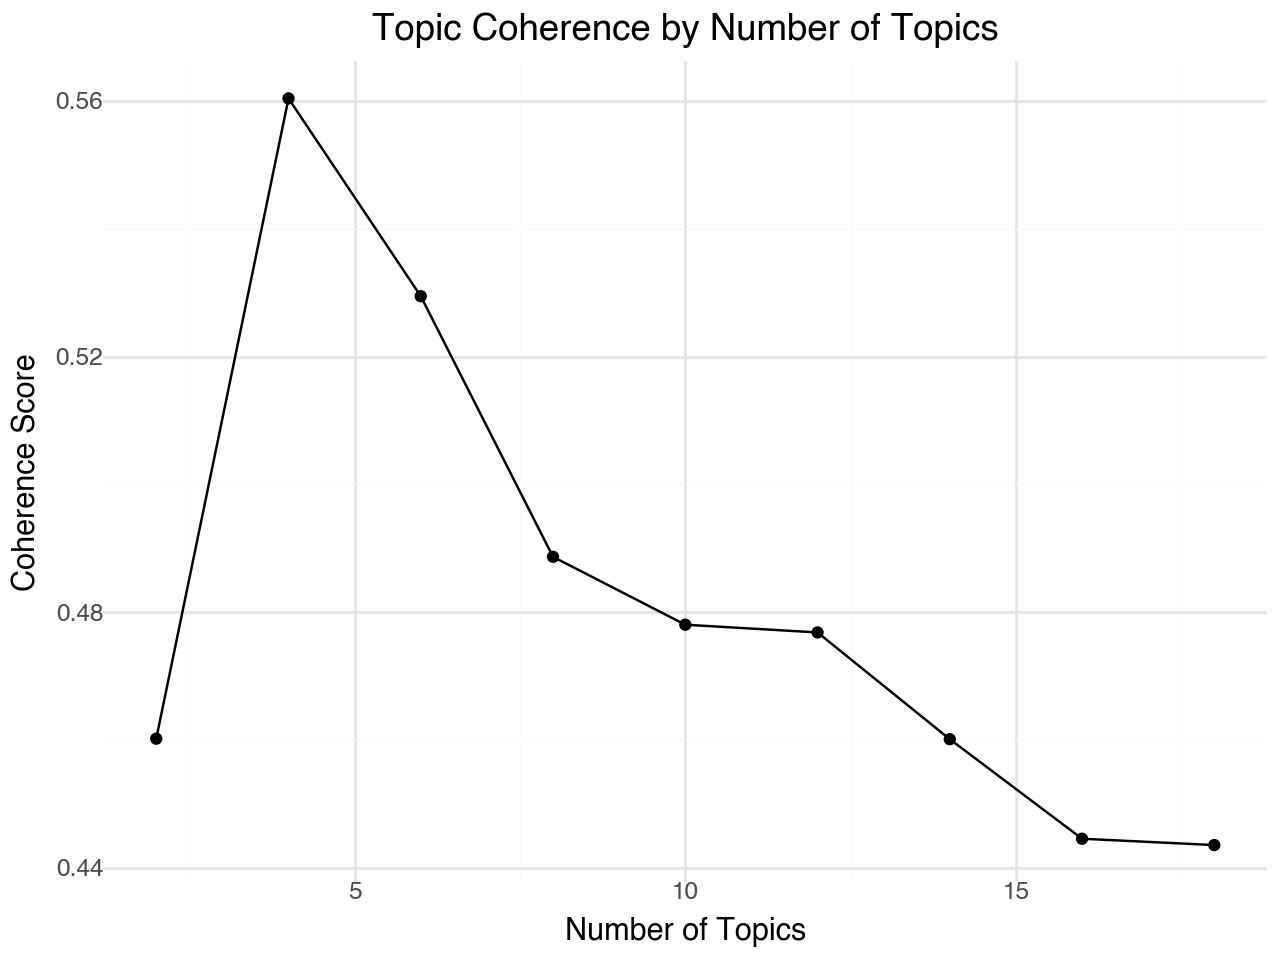

In [53]:
# visualize
topic_range = list(range(2, 20, 2))

infra_df_plot = pd.DataFrame({
    "num_topics": topic_range,
    "coherence": coherence_values_infra
})

(
    ggplot(infra_df_plot, aes(x="num_topics", y="coherence"))
    + geom_line()
    + geom_point()
    + labs(
        title="Topic Coherence by Number of Topics",
        x="Number of Topics",
        y="Coherence Score"
    )
    + theme_minimal()
)

In [54]:
lda_model_infra = LdaModel(
    corpus=corpus_infra,
    id2word=dictionary_infra,
    num_topics=4,
    random_state=42,
    passes=10,
    alpha="auto"
)

for i, topic in lda_model_infra.show_topics(num_topics=4, num_words=10, formatted=False):
    print(f"Topic {i}: {[w for w, p in topic]}")

Topic 0: ['employee', 'year', 'company', 'job', 'like', 'one', 'safety', 'care', 'people', 'worked']
Topic 1: ['get', 'time', 'hour', 'long', 'day', 'lot', 'working', 'small', 'paid', 'pay']
Topic 2: ['management', 'staff', 'project', 'manager', 'senior', 'poor', 'way', 'leadership', 'level', 'people']
Topic 3: ['good', 'company', 'great', 'project', 'opportunity', 'people', 'benefit', 'working', 'place', 'salary']
